# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 32

**Author 1 (sciper):** Julien Daniel Berger (247179)    
**Author 2 (sciper):** Ghali Chraibi (262251)     
**Author 3 (sciper):** Yasser Haddad (272292)    

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports

In [1]:
import tarfile
import os
import gzip

import math
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.transforms import ToTensor

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
data_base_path = 'data'
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


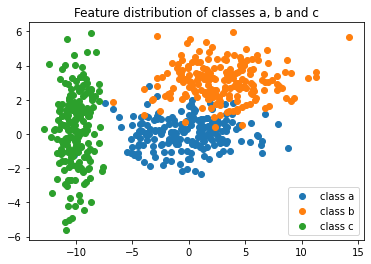

In [5]:
# Plot the classes to have an overall idea
fig, ax = plt.subplots()

ax.scatter(a[:,0], a[:,1])
ax.scatter(b[:,0], b[:,1])
ax.scatter(c[:,0], c[:,1])
ax.legend(["class a", "class b", "class c"])
ax.set_title("Feature distribution of classes a, b and c")

plt.show()

### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

### Background

The Bayes method used to classify objects computes the probability that a point belongs in one class or another assuming we know the probability distribution functions of the objects in the classes as well as the class priors.  
The principal **assumption** done here is that the probability distribution functions of the classes are gaussian. If we look at the density plots of each class (ploted below), we can see that this assumption seems reasonable (the histograms are symmetrical and have a bell curve shape).

A **separation curve** contains the set of points where the probability to classify a sample in two different classes $i,j$ is the same:  

$$P(w_i|x) = P(w_j|x)$$

Using Bayes theorem, this is equivalent to  

$${P(x|w_i)P(w_i)} = {P(x|w_j)P(w_j)}$$

Each side of the equation can be expressed by a discriminant function as follows (assuming gaussian distribution of features):

\begin{equation}
g_i(x) = \ln(p(x|w_i)P(w_i)) = \ln(p(x|w_i))+\ln(P(w_i)) = -\frac{1}2 (x-\mu_i)^T \Sigma_i^-1 (x-\mu_i) + \ln(P(w_i)) +c_i
\end{equation}

The expression of the separation curves is described as $g_{i,j}(x) = g_i(x) - g_j(x) = 0$.  
Note that here, since the training sets of each of the 3 classes have the same number of points, they all have a prior $P(w_i)=1/3$.
By doing the substraction of two discriminant functions ($g_{i}$ and $g_{j}$), the prior terms cancel out.
We can therefore neglect them in the calculation of the discriminant function and we obtain:  

\begin{equation}g_i(x) = -\frac{1}2 (x-\mu_i)^T \Sigma_i^-1 (x-\mu_i) + c_i \end{equation}


In [6]:
# Transform data into pandas DataFrame 
a_df = pd.DataFrame(a)
a_df.columns = ["feature 1", "feature 2"]
b_df = pd.DataFrame(b)
b_df.columns = ["feature 1", "feature 2"]
c_df = pd.DataFrame(c)
c_df.columns = ["feature 1", "feature 2"]

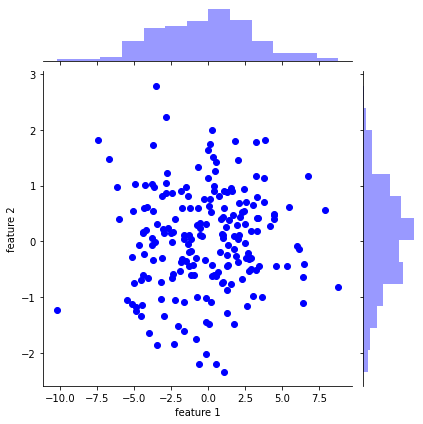

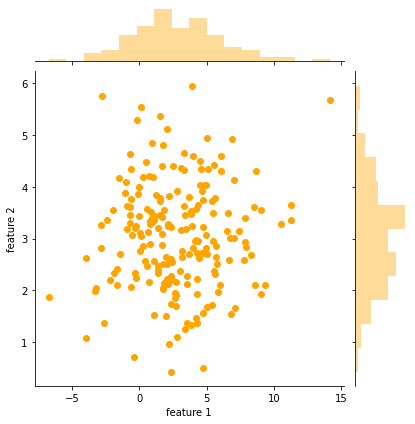

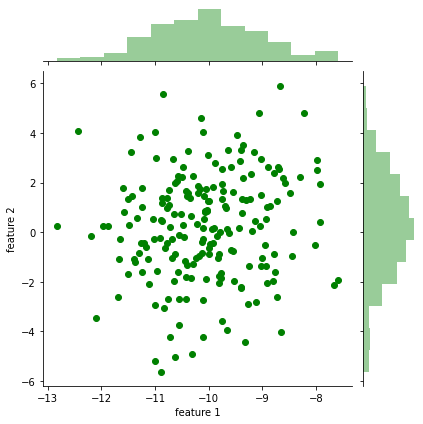

In [8]:
# Plot features for the 3 classes in order to check normality assumption
sns.jointplot(data=a_df, x="feature 1", y="feature 2", color="blue", label='Class a')
sns.jointplot(data=b_df, x="feature 1", y="feature 2", color="orange", label='Class b')
sns.jointplot(data=c_df,  x="feature 1", y="feature 2", color="green", label="Class c")
plt.show()

In the graph above, we support that the gaussian assumption is valid.

In [9]:
# Calculate the covariance matrixes and mean vectors for each class
mean_a = a_df.mean()
cov_a = a_df.cov()

mean_b = b_df.mean()
cov_b = b_df.cov()

mean_c = c_df.mean()
cov_c = c_df.cov()

In [10]:
cov_a

,feature 1,feature 2
feature 1,10.027697,0.131623
feature 2,0.131623,0.839327


In [11]:
cov_b

,feature 1,feature 2
feature 1,10.170348,0.180238
feature 2,0.180238,1.084004


In [12]:
cov_c

,feature 1,feature 2
feature 1,0.970130,0.234581
feature 2,0.234581,4.697563


Since covariate matrixes are not equal, we won't obtain straight seperation lines but more complex quadrics. However, for classes a and b, the matrixes are not so different so we should obtain something close to a line.

In [14]:
# Function that computes the discriminat function for a given class
def discriminant(x, mean, cov):
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    g = -0.5*np.dot(np.dot(np.transpose(x-mean), np.linalg.inv(cov)), x-mean) \
        + math.log(1/(2*math.pi*(np.linalg.det(cov)**0.5)))
    return g 

In [15]:
# Create a meshgrid that spans the entire feature space 
features_tot = pd.concat([a_df, b_df,c_df], axis=0)
max_df = features_tot.max()
min_df = features_tot.min()

rangeF1 = np.arange(min_df['feature 1'], max_df['feature 1'], 0.1) 
rangeF2 = np.arange(min_df['feature 2'], max_df['feature 2'], 0.1)

gridF1, gridF2 = np.meshgrid(rangeF1, rangeF2)

meshgrid = np.dstack((gridF1, gridF2))
meshgrid_ = np.reshape(meshgrid,(meshgrid.shape[0]*meshgrid.shape[1], meshgrid.shape[2]))

In [16]:
# Calculate the disciminants for each class
g_a = [discriminant(x, mean_a, cov_a) for x in list(meshgrid_)]
g_b = [discriminant(x, mean_b, cov_b) for x in list(meshgrid_)]
g_c = [discriminant(x, mean_c, cov_c) for x in list(meshgrid_)]

# Calculate gi(xi) - gj(x) for each pair of class
g_ab = np.array(g_a) - np.array(g_b) 
g_bc = np.array(g_b) - np.array(g_c)
g_ac = np.array(g_a) - np.array(g_c)

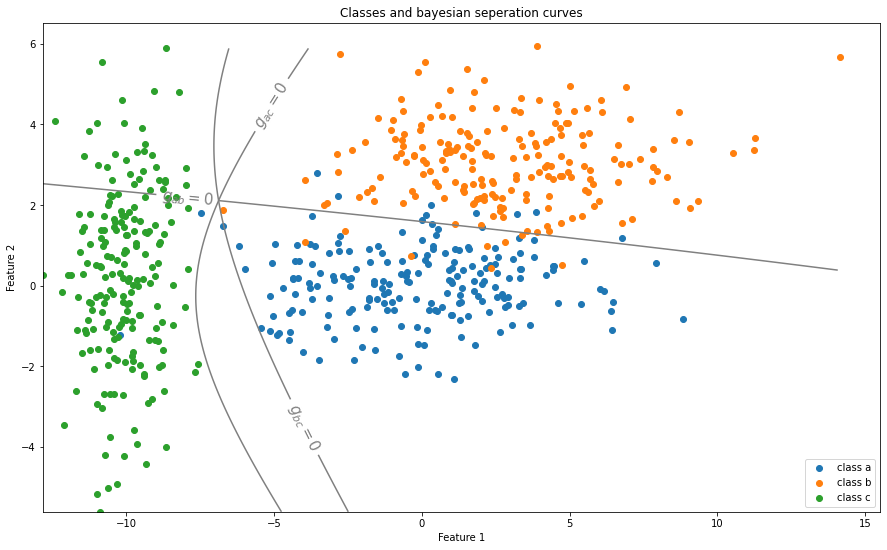

In [18]:
# Plot the classes
fig, ax = plt.subplots(figsize=(15,9))
ax.scatter(a[:,0], a[:,1])
ax.scatter(b[:,0], b[:,1])
ax.scatter(c[:,0], c[:,1])
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Classes and bayesian seperation quadrics")
ax.legend(["class a", "class b", "class c"])

# Plot the seperation curves using the plt.contour method
contour_ab = ax.contour(gridF1, gridF2, g_ab.reshape(gridF1.shape),0, colors = "gray")
contour_bc = ax.contour(gridF1, gridF2, g_bc.reshape(gridF1.shape),0, colors = "gray")
contour_ac = ax.contour(gridF1, gridF2, g_ac.reshape(gridF1.shape),0, colors = "gray")

ax.clabel(contour_ab, inline=True, fmt='$g_{ab} = 0$', fontsize=15)
ax.clabel(contour_bc, inline=True, fmt='$g_{bc} = 0$', fontsize=15)
ax.clabel(contour_ac, inline=True, fmt='$g_{ac} = 0$', fontsize=15)
plt.show()

Looking at the separation line between class a and class b ($g_{ab}$ = 0), it confirms the guess we have made based on the covariance matrices that the latter is close to a straight line.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [ ]:
#### BACKGROUND ####

In [21]:
def mahalanobis(x, mean, cov):
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    return np.sqrt(np.dot(np.dot(np.transpose(x-mean), np.linalg.inv(cov)), x-mean)) 

The following cell allows to plot the line corresponding to the mahalanobis classifier. For this approximation, we took the mean between the covariance matrix of each class to have a similar covariance matrix between the two classes,.

In [22]:
# Create a meshgrid that spans the feature space of clusters a and b
features_ab = pd.concat([a_df,b_df], axis=0)
max_f = features_ab.max()
min_f = features_ab.min()

cov_ab_maha = (np.array(cov_a) + np.array(cov_b))/2 # covariance matrix is the mean of matrixes a and b

rangeF1 = np.arange(min_df['feature 1'], max_df['feature 1'], 0.1) 
rangeF2 = np.arange(min_df['feature 2'], max_df['feature 2'], 0.1)

gridF1_maha, gridF2_maha = np.meshgrid(rangeF1, rangeF2)

meshgrid_ab = np.dstack((gridF1_maha, gridF2_maha))
meshgrid_ab = np.reshape(meshgrid_ab,(meshgrid_ab.shape[0]*meshgrid_ab.shape[1], meshgrid_ab.shape[2]))

maha_a = [mahalanobis(x, mean_a, cov_ab_maha) for x in list(meshgrid_ab)]
maha_b = [mahalanobis(x, mean_b, cov_ab_maha) for x in list(meshgrid_ab)]

maha_ab = np.array(maha_a) - np.array(maha_b) # Mahalanobis Seperation curve to be plotted

The following cell allows to plot the separation line corresponding to the optimal bayesian classifier as done in part 1.1. In this case there is no euclidian or mahalanobis approximation. 

In [23]:
g_a = [discriminant(x, mean_a, cov_a) for x in list(meshgrid_ab)]
g_b = [discriminant(x, mean_b, cov_b) for x in list(meshgrid_ab)]
g_ab = np.array(g_a)-np.array(g_b) # Optimal seperation curve to be plotted

The following cell allows to plot a separation line using the euclidian distance as . For this approximation, The covariance matrix for classes a and b is a diagonal matrix with the diagonal corresponding to the mean of the original covariance matrixes

In [24]:
def euclidian(x, mean, cov):
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    g = -0.5*np.dot(np.dot(np.transpose(x-mean), np.linalg.inv(cov)), x-mean) + math.log(1/(2*math.pi*(np.linalg.det(cov)**0.5)))
    return g  

cov_ab_eucl = cov_ab_maha
cov_ab_eucl[0,1] = 0
cov_ab_eucl[1,0] = 0

eucl_a = [euclidian(x, mean_a, cov_ab_eucl) for x in list(meshgrid_ab)]
eucl_b = [discriminant(x, mean_b, cov_ab_eucl) for x in list(meshgrid_ab)]
eucl_ab = np.array(eucl_a)-np.array(eucl_b) # Euclidien curve to be plotted

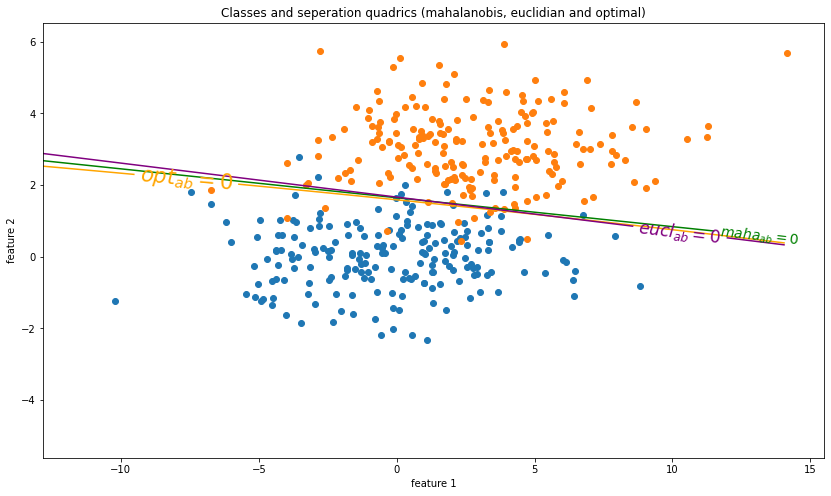

In [26]:
# This cell plots all the seperation lines
plt.subplots(figsize=(14,8))
plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])
plt.title("Classes and seperation quadrics (mahalanobis, euclidian and optimal)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

maha_contour_ab = plt.contour(gridF1_maha, gridF2_maha, maha_ab.reshape(gridF1_maha.shape),0, colors = "green")
g_contour_ab = plt.contour(gridF1_maha, gridF2_maha, g_ab.reshape(gridF1_maha.shape),0, colors = "orange")
eucl_contour_ab = plt.contour(gridF1_maha, gridF2_maha, eucl_ab.reshape(gridF1_maha.shape),0, colors = "purple")

plt.clabel(maha_contour_ab, inline=True, fmt='$maha_{ab} = 0$', fontsize=14)
plt.clabel(g_contour_ab, inline=True, fmt='$opt_{ab} = 0$', fontsize=21)
plt.clabel(eucl_contour_ab, inline=True, fmt='$eucl_{ab} = 0$', fontsize=17)
plt.show()

### Accuracy of the different classifiers

In order to know the number of samples that are correctly classified in class A and class B, we can iterate on the samples of class A and B and count how many times P(x|classA) > P(x|classB) for class A accuracy and how many times P(x|classB) > p(x|classA) for class B accuracy.

#### Optimal classifier (no approximations)

In [28]:
g_ab = []
for i in range(a.shape[0]):
    g = discriminant(list(a)[i], mean_a, cov_a) > discriminant(list(a)[i], mean_b, cov_b)
    g_ab.append(g)

print("the number of objects in class A that are well classified is", sum(g_ab))

g_ba = []
for i in range(b.shape[0]):
    g = discriminant(list(b)[i], mean_b, cov_b) > discriminant(list(b)[i], mean_a, cov_a)
    g_ba.append(g)

print("the number of objects in class B that are well classified is", sum(g_ab))

the number of objects in class A that are well classified is 190
the number of objects in class B that are well classified is 190


#### Mahalanobis classifier

In [29]:
m_ab = []
for i in range(a.shape[0]):
    m = mahalanobis(list(a)[i], mean_a, cov_ab_maha) < mahalanobis(list(a)[i], mean_b, cov_ab_maha)
    m_ab.append(m)

print("the number of objects in class a that are well classified is", sum(m_ab))

m_ba = []
for i in range(b.shape[0]):
    m = mahalanobis(list(b)[i], mean_b, cov_ab_maha) < mahalanobis(list(b)[i], mean_a, cov_ab_maha)
    m_ba.append(m)

print("the number of objects in class b that are well classified is", sum(m_ba))

the number of objects in calss a that are well classified is 192
the number of objects in calss b that are well classified is 190


#### Euclidian classifier

In [30]:
e_ab = []
for i in range(a.shape[0]):
    e = euclidian(list(a)[i], mean_a, cov_ab_eucl) > euclidian(list(a)[i], mean_b, cov_ab_eucl)
    e_ab.append(e)

print("the number of objects in class a that are well classified is", sum(e_ab))

e_ba = []
for i in range(b.shape[0]):
    e = euclidian(list(b)[i], mean_b, cov_ab_eucl) > euclidian(list(b)[i], mean_a, cov_ab_eucl)
    e_ba.append(e)

print("the number of objects in class a that are well classified is", sum(e_ba))

the number of objects in calss a that are well classified is 192
the number of objects in calss a that are well classified is 190


We observe that the 3 classifiers perform very similarly. However, the mahalanobis and euclidien perform a bit better. This is not what we would expect since these are approximations of the optimal quadric.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [6]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [7]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

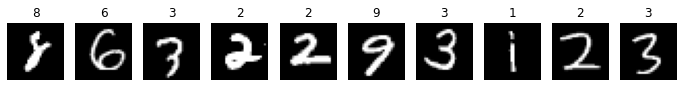

In [8]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [9]:
class MNISTDataset(data.Dataset):
    def __init__(self, imgs, labels, transform):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        data = self.imgs[idx]
        if self.transform:
            data = self.transform(data)
        return (data, self.labels[idx])

In [10]:
# Parameters of our DataLoader
params = {'batch_size': 128,
          'shuffle': True}

# Creation of a train/test dataset & dataloader
ds_train = MNISTDataset(train_images, train_labels, transform=ToTensor())
dl_train = data.DataLoader(ds_train, **params)

ds_test = MNISTDataset(test_images, test_labels, transform=ToTensor())
dl_test = data.DataLoader(ds_test, **params)

In [11]:
# Definition and instanciation of our network
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)    
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
net = Network()

In [12]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [13]:
# Optimizer
learning_rate = 1e-4
opt = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
def train_loop(dataloader, model, loss_func, optimizer):
    for it, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)            # Forward pass
        loss = loss_func(pred, y)  # Compute the loss

        # Backpropagation
        optimizer.zero_grad()      # Reinitialise the accumulated gradients
        loss.backward()            # Recompute the new gradients
        optimizer.step()           # Update the parameters of the model
        
        # Compute the accuracy on this batch of images
        accuracy_tr = (pred.argmax(1) == y).type(torch.float).sum().item() / len(X)
        
        if (it+1 == len(dataloader)):
            print('It {}/{}:\n Loss train: {:.5f}, Accuracy train: {:.2%}'.
                  format(it + 1, len(dataloader), loss, accuracy_tr, end=''))
    print()

In [15]:
def test_loop(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    test_loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Statistics over all the batchs
    test_loss /= size
    accuracy /= size    
    
    print(f"Test Error: \n Avg loss: {test_loss:.5f}, Accuracy: {accuracy:.2%} \n")

In [16]:
epochs = 15

# Train & test our model until convergence (here 15 epochs is sufficient as we don't have too many parameters)
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loop(dl_train, net, criterion, opt)
    test_loop(dl_test, net, criterion)

Epoch 1
-------------------------------
It 469/469:
 Loss train: 0.40838, Accuracy train: 90.62%

Test Error: 
 Avg loss: 0.00585, Accuracy: 89.16% 

Epoch 2
-------------------------------
It 469/469:
 Loss train: 0.29065, Accuracy train: 90.62%

Test Error: 
 Avg loss: 0.00390, Accuracy: 91.18% 

Epoch 3
-------------------------------
It 469/469:
 Loss train: 0.34859, Accuracy train: 93.75%

Test Error: 
 Avg loss: 0.00314, Accuracy: 92.48% 

Epoch 4
-------------------------------
It 469/469:
 Loss train: 0.50323, Accuracy train: 91.67%

Test Error: 
 Avg loss: 0.00252, Accuracy: 93.69% 

Epoch 5
-------------------------------
It 469/469:
 Loss train: 0.22816, Accuracy train: 96.88%

Test Error: 
 Avg loss: 0.00226, Accuracy: 94.18% 

Epoch 6
-------------------------------
It 469/469:
 Loss train: 0.33291, Accuracy train: 92.71%

Test Error: 
 Avg loss: 0.00204, Accuracy: 94.79% 

Epoch 7
-------------------------------
It 469/469:
 Loss train: 0.12119, Accuracy train: 95.83%

Te

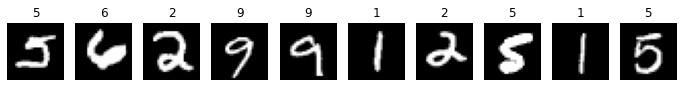

In [31]:
for X, y in dl_test:
    # Predict the labels of one batch of images
    pred = net(X)
    labels = pred.argmax(1)

    # Plot some arbitrary pair of (image, predicted label) to see our model in action
    fig, axes = plt.subplots(1, 10, figsize=(12, 3))
    for ax, idx in zip(axes, range(10)):
        ax.imshow(X[idx, 0], cmap='gray')
        ax.axis('off')
        ax.set_title(labels[idx].item())
    plt.show()
    break

#### Discussion

Using a simple Multilayer Perceptron model we obtain an accuracy of TODO %

To improve the accuracy, we could:
- add hidden layers (1 or 2, but not too much otherwise we would have too many parameters to train in comparison to the data available).
- use a CNN (Convolutional Neural Network) which uses the spatial informations of the images and therefore is more suited for a pattern recognition task. Note that using only fully connected layers, we don't have a proper way to extract the features from our digits as a CNN would and the process is rather blackboxed.  

To train the best model using the same simple architecture, we tested several hyperparameters (the size of the batches, the number of epochs and the learning rate).   
We observed that the model converged after 15 epochs, using a learning rate of 1e-4. Different values of learning rate gave us often some very bad accuracy, the model converging too slowly or diverging. The worst we obtained was around 10% which corresponds to a random guess (as we have 10 possible digits).